# Vodafone challenge

In [32]:
# Import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

# Import evaluation libraries
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Import model libraries
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

# Random seed for reproducibility
seed = 202
np.random.seed(seed)

## import, clean and sort the dataset

In [33]:
# Import the train set and test set
train_data = pd.read_csv("cat_train.csv", delimiter=",")
test_data = pd.read_csv("cat_test.csv", delimiter=",")

# Drop the ID column
train_data = train_data.drop('ID', axis=1)
train_data = train_data.drop('Regions_Cluster', axis=1)
# Sort the dataset
train_data = train_data.iloc[np.random.permutation(len(train_data))]
train_data = train_data.reset_index(drop=True)

train_data.fillna(999999, inplace=True)
test_data.fillna(999999, inplace=True)

## select the number of features

In [34]:
array = np.asarray(train_data)

# X,Y are the splits between features and labels used to evaluate SelectKBest
X = array[:,0:train_data.shape[1]-1]
X = np.asarray(X)
Y = array[:,train_data.shape[1]-1]
Y = np.asarray(Y)

# Evaluate the features with a chi2 test by using SelectKBest
# It must be at most max_feature_number - 1
feature_number = 29

chi2_test = SelectKBest(score_func=chi2, k=feature_number)
fit = chi2_test.fit(X,Y)

In [35]:
def features_labels_split(data):
    
    features = data[train_data.columns[chi2_test.get_support(indices=True)]]
    labels = data['Product']
    return features, labels

In [37]:
def train_test_validation_split(features, labels, val_samples, test_samples):

    features = np.asarray(features)
    labels =np.asarray(labels)
    
    X_test = features[0:test_samples]
    y_test = labels[0:test_samples]

    X_val = features[test_samples:test_samples + val_samples]
    y_val = labels[test_samples:test_samples + val_samples]

    X_train = features[test_samples + val_samples:]
    y_train = labels[test_samples + val_samples:]

    return X_train, X_test, X_val, y_train, y_test, y_val

## data creation

In [38]:
# Import the train set and test set
train_data = pd.read_csv("cat_train.csv", delimiter=",")
test_data = pd.read_csv("cat_test.csv", delimiter=",")

# Drop the ID column
train_data = train_data.drop('ID', axis=1)
train_data = train_data.drop('Regions_Cluster', axis=1)
# Sort the dataset
train_data = train_data.iloc[np.random.permutation(len(train_data))]
train_data = train_data.reset_index(drop=True)

train_data.fillna(-999, inplace=True)
test_data.fillna(-999, inplace=True)

In [39]:
train_feat, train_label = features_labels_split(train_data)

num_val_samples = 0
num_test_samples = 950
X_train, X_test, X_val, y_train, y_test, y_val = train_test_validation_split(train_feat, train_label, num_val_samples, num_test_samples)

## catboosting

## training comparison

GradientBoosting: 0.611 (+/-0.020)
ExtremeGradintBoosting: 0.611 (+/-0.018)
CatBoosting: 0.614 (+/-0.012)


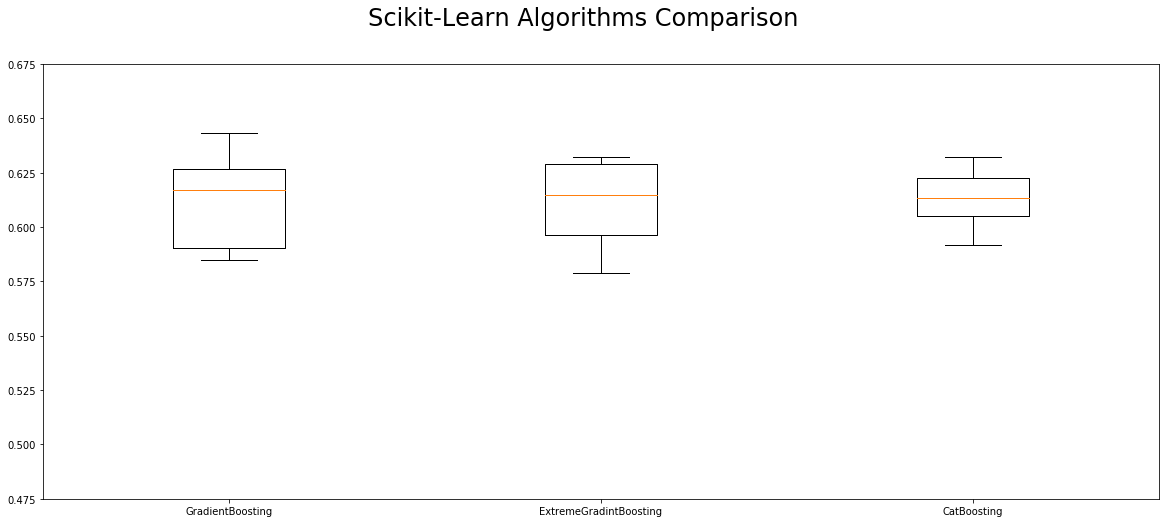

In [47]:
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from catboost import CatBoostClassifier


# Build the default models to select the best one  
# The commented classifiers are weak
dtc = DecisionTreeClassifier()
bnb = BernoulliNB()
xtc = ExtraTreesClassifier()
nb = GaussianNB()
qda = QuadraticDiscriminantAnalysis()
lr = LogisticRegression()
lda = LinearDiscriminantAnalysis()
ada = AdaBoostClassifier()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
gbc = GradientBoostingClassifier()
perc = Perceptron()
paggr = PassiveAggressiveClassifier()
svc = SVC()
lsvc = LinearSVC()
sgd = SGDClassifier()
xgb = XGBClassifier(n_jobs=-1, objective='multi:softmax', random_state=seed)
cbc = CatBoostClassifier(random_seed=seed,logging_level='Silent',loss_function='MultiClassOneVsAll',)

# Append all the models into an array
models = []
models.append(('GradientBoosting', gbc))
models.append(('ExtremeGradintBoosting', xgb))
models.append(('CatBoosting', cbc))
#models.append(('RandomForest', rf))
#models.append(('GaussianNB', nb))
#models.append(('GradientBoosting', gbc))
#models.append(('AdaBoosting', ada))
#models.append(('QDA', qda))
#models.append(('ExtraTrees', xtc))
#models.append(('LogisticRegression', lr))



from sklearn.model_selection import cross_val_score


# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_micro', n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (+/-%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(20, 8))
fig.suptitle('Scikit-Learn Algorithms Comparison', fontsize=24)
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
plt.ylim([0.475,0.675])
ax.set_xticklabels(names)
plt.show()

In [ ]:
SupportVectorMachine: 0.561 (+/-0.015)
LogisticRegression: 0.567 (+/-0.016)
LDA: 0.564 (+/-0.015)
KNearestNeighbors: 0.530 (+/-0.022)
RandomForest: 0.577 (+/-0.022)
GradientBoosting: 0.601 (+/-0.015)
DecisionTree: 0.472 (+/-0.016)
AdaBoosting: 0.586 (+/-0.019)
QDA: 0.516 (+/-0.016)
ExtremeTrees: 0.568 (+/-0.013)

    
SupportVectorMachine: 0.543 (+/-0.017)
LogisticRegression: 0.543 (+/-0.022)
LDA: 0.584 (+/-0.023)
KNearestNeighbors: 0.555 (+/-0.016)
RandomForest: 0.581 (+/-0.015)
GradientBoosting: 0.608 (+/-0.021)
DecisionTree: 0.482 (+/-0.020)
AdaBoosting: 0.583 (+/-0.019)
QDA: 0.582 (+/-0.023)
ExtremeTrees: 0.583 (+/-0.024)

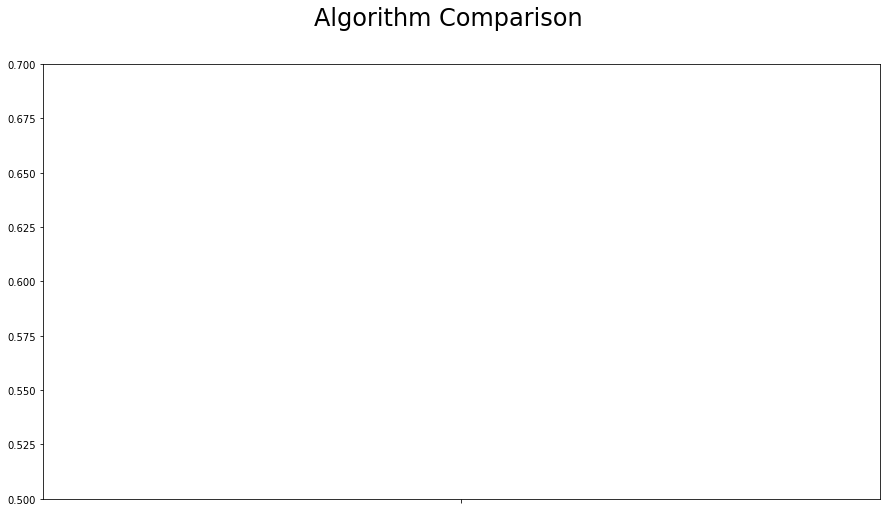

In [58]:
tuned_xgb = XGBClassifier(learning_rate=0.02, n_estimators=450,
                           max_depth = 6, min_child_weight=4,
                           subsample=0.8, colsample_bytree=0.8,
                           reg_alpha=0.6, reg_lambda=0.8,
                           n_jobs=-1, objective='multi:softmax', random_state=seed)
#base_xgb = XGBClassifier(n_jobs=-1, objective='multi:softmax', random_state=seed)


ada = AdaBoostClassifier(learning_rate=0.3, n_estimators=300, random_state=seed)
rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=1, n_jobs=-1, random_state=seed)

voting = VotingClassifier(estimators=[('xgb', tuned_xgb), ('ada', ada), ('rf', rf)],
                          voting='soft', weights=[0.8,0.5,0.6],
                          n_jobs=-1)

# Append all the models into an array
models = []
#models.append(('XGB', tuned_xgb))
#models.append(('baseXGB', base_xgb))

#models.append(('RF', rf))
#models.append(('ADA', ada))
#models.append(('VOTING', voting))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_micro', n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison', fontsize=24)
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
plt.ylim([0.50,0.70])
ax.set_xticklabels(names)
plt.show()

## Computing best features
Before starting the tuning phase, we chose the best number of features for each classifier and we plotted the best (mean) performances that we could observe performing a complete exploration of all the possibilities.

Model: SupportVectorMachine, Avg_Score: 0.598, Num_Feat: 28
Model: LDA, Avg_Score: 0.593, Num_Feat: 15
Model: KNearestNeighbors, Avg_Score: 0.568, Num_Feat: 6
Model: RandomForest, Avg_Score: 0.593, Num_Feat: 27
Model: GaussianNB, Avg_Score: 0.582, Num_Feat: 2
Model: GradientBoosting, Avg_Score: 0.611, Num_Feat: 27
Model: AdaBoosting, Avg_Score: 0.591, Num_Feat: 27
Model: QDA, Avg_Score: 0.590, Num_Feat: 15
Model: ExtraTrees, Avg_Score: 0.586, Num_Feat: 28
Model: LogisticRegression, Avg_Score: 0.594, Num_Feat: 17


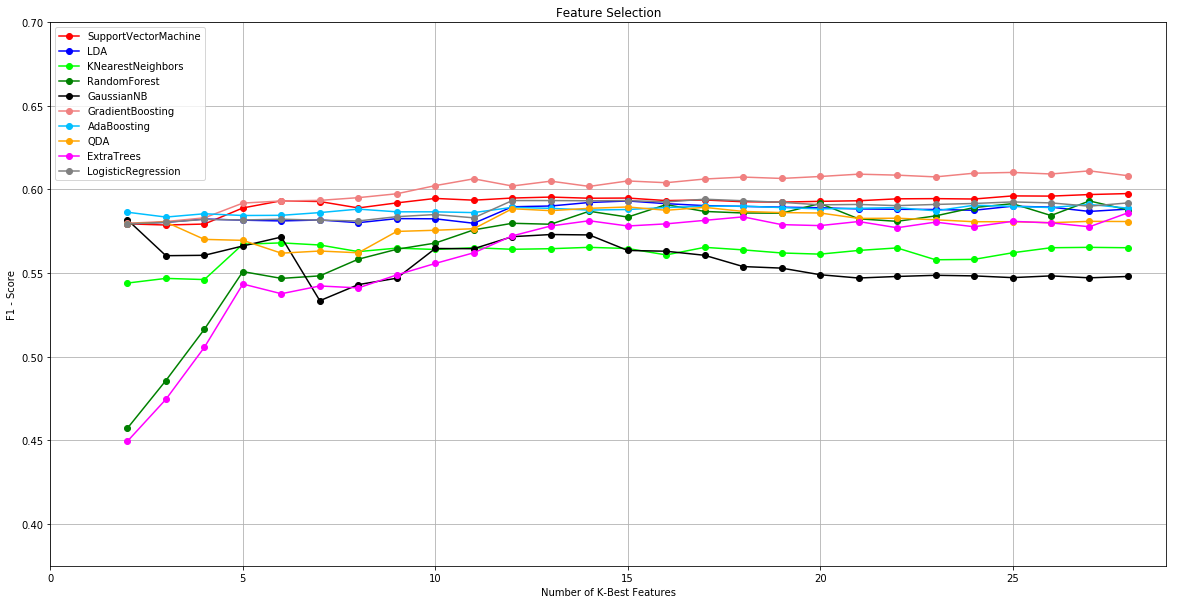

In [45]:
# Append all the models into an array
models = []
models.append(('SupportVectorMachine', svc, 'Red'))
models.append(('LDA', lda,'Blue'))
models.append(('KNearestNeighbors', knn, 'Lime'))
models.append(('RandomForest', rf, 'Green'))
models.append(('GaussianNB', nb, 'Black'))
models.append(('GradientBoosting', gbc, 'lightcoral'))
models.append(('AdaBoosting', ada, 'deepskyblue'))
models.append(('QDA', qda, 'Orange'))
models.append(('ExtraTrees', xtc, 'Magenta'))
models.append(('LogisticRegression', lr, 'Grey'))
#models.append(('XGB', xgb, 'Cyan'))


feat_range = X_train.shape[1]

n = ['SupportVectorMachine', 'LDA', 'KNearestNeighbors', 'RandomForest', 'GaussianNB', 'GradientBoosting', 'AdaBoosting', 'QDA', 'ExtraTrees', 'LogisticRegression']
n_number = np.arange(2,feat_range,1)
# Transforming the lists into array for plotting
plt.figure(figsize=(20, 10))
plt.title('Feature Selection')
plt.xlabel("Number of K-Best Features")
plt.ylabel("F1 - Score")
plt.grid()

num_feat_arr = []
for name, model, c in models:
    
    scores = [0, 0]
    results = []

    for n in range(2,feat_range):

        selection = SelectKBest(k=n).fit(X_train,y_train)
        X_k = selection.transform(X_train)
        
        
        # Feature Scaling
        from sklearn.preprocessing import StandardScaler
        sc = StandardScaler()
        X_k = sc.fit_transform(X_k)
        
        score = cross_val_score(estimator = model, X = X_k, y = y_train, cv = 5, scoring='f1_micro')
        f1 = score.mean()
        
        results.append(f1)
        
        std = score.std()
        if scores[0] < f1:
            scores = [f1, n]
  
    plt.plot(n_number, results, 'o-', color=c, label=name)
    
    num_feat_arr.append(scores[1])
    max_avg = np.average(scores)
    
    print("Model: %s, Avg_Score: %.3f, Num_Feat: %d" % (name, scores[0], scores[1]))  


plt.axis([0, feat_range , 0.375, 0.70])
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
plt.show()

## Extreme Gradient Boosting hyperparameters tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

classifier = XGBClassifier(learning_rate=0.02, n_estimators=450,
                           max_depth = 6, min_child_weight=4,
                           subsample=0.8, colsample_bytree=0.8,
                           reg_alpha=0.6, reg_lambda=0.8,
                           n_jobs=-1, objective='multi:softmax', random_state=seed)

learning_rate = np.arange(0.01,0.05,0.01)
n_estimators = np.arange(400,700,50)

max_depth = np.arange(2,10,1)
min_child_weight = np.arange(1,7,1)

gamma = np.arange(0.0,0.5,0.1)

subsample = (0.75,0.8,0.85)
colsample_bytree = (0.75,0.8,0.85)

reg_alpha = (0.6,0.65,0.55)
reg_lambda = (0.8,0.85,0.75)

parameters = [{
    'n_estimators':n_estimators
               }]

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring='f1_micro',
                           cv = 5,
                           n_jobs = -1)

grid_search = grid_search.fit(X_train, y_train)
best_f1 = grid_search.best_score_
best_parameters = grid_search.best_params_
print(best_f1)
print(best_parameters)

## Soft Voting hyperparameters tuning

In [98]:
df = pd.DataFrame(columns=('w1', 'w2', 'w3', 'mean', 'std'))

i = 0
for w1 in (0.5,1,1.5):
    for w2 in (0.5,1,1.5):
        for w3 in (0.5,1,1.5):

            if len(set((w1,w2,w3))) == 1: # skip if all weights are equal
                continue

            voting = VotingClassifier(estimators=[('xgb', tuned_xgb), ('ada', ada), ('rf', rf)],
                          voting='soft', weights=[w1,w2,w3], n_jobs=-1)
            scores = cross_val_score(
                                estimator=voting,
                                X=X_train,
                                y=y_train,
                                cv=5,
                                scoring='f1_micro',
                                n_jobs=-1)
            print("XGB:%.1f, ADA:%.1f, RF:%.1f f1=%.3f (+/- %.3f)" % (w1, w2, w3, scores.mean(), scores.std()))
            df.loc[i] = [w1, w2, w3, scores.mean(), scores.std()]
            i += 1

df.sort(columns=['mean', 'std'], ascending=False)

XGB:0.5, ADA:0.5, RF:1.0 f1=0.604 (+/- 0.006)
XGB:0.5, ADA:0.5, RF:1.5 f1=0.603 (+/- 0.007)
XGB:0.5, ADA:1.0, RF:0.5 f1=0.605 (+/- 0.006)
XGB:0.5, ADA:1.0, RF:1.0 f1=0.604 (+/- 0.006)
XGB:0.5, ADA:1.0, RF:1.5 f1=0.603 (+/- 0.007)
XGB:0.5, ADA:1.5, RF:0.5 f1=0.605 (+/- 0.006)
XGB:0.5, ADA:1.5, RF:1.0 f1=0.604 (+/- 0.006)
XGB:0.5, ADA:1.5, RF:1.5 f1=0.603 (+/- 0.007)


KeyboardInterrupt: 

In [34]:
# Test Performance

test_model = XGBClassifier(learning_rate=0.02, n_estimators=450,
                           max_depth = 6, min_child_weight=4,
                           subsample=0.8, colsample_bytree=0.8,
                           reg_alpha=0.6, reg_lambda=0.8,
                           n_jobs=-1, objective='multi:softmax', random_state=seed)
test_model.fit(X_train, y_train)
y_pred = test_model.predict(X_test)
# F1
print("F1 score on unseen data: %.3f" % f1_score(y_test, y_pred, average='micro'))

F1 score on unseen data: 0.606


c:\users\eugen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [35]:
X_pred = test_data[train_data.columns[chi2_test.get_support(indices=True)]]

In [36]:
classifier = XGBClassifier(learning_rate=0.03, n_estimators=300,
                           max_depth = 6, min_child_weight=4,
                           subsample=0.8, colsample_bytree=0.8,
                           reg_alpha=0.6, reg_lambda=0.8,
                           n_jobs=-1, objective='multi:softmax', random_state=seed)
classifier.fit(train_feat, train_label)
y_pred = classifier.predict(X_pred)

c:\users\eugen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [37]:
submit = test_data['ID']
submit = pd.DataFrame({'ID': submit})

pred = y_pred
pred = pd.DataFrame({'Product': y_pred})

product = []
product = pred.Product
product.replace({ 
    int(0) : 'Non-Customer', 
    int(1) : 'V-Auto', 
    int(2) : 'V-Bag', 
    int(3) : 'V-Pet'},
    inplace=True)

submit = submit.join(product)
submit.to_csv('Main_prediction.csv', index = False, encoding='utf-8')